In [3]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import copy
import umap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import pickle
import hdbscan
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn import metrics
# https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#fig:clustfg3
# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# KMEANS 
### con diferentes k respecto de la metrica NMI (normalized mutual info score), que es con la cual puedo hacer el trade-off entre k y la calidad del clustering 
segun https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#fig:clustfg3

In [5]:
with open('data/trainReduced300', 'rb') as file:
    trainReduced300 = pickle.load(file)
with open('data/valReduced300', 'rb') as file:
    valReduced300 = pickle.load(file)
with open('data/testReduced300', 'rb') as file:
    testReduced300 = pickle.load(file)
    
with open('data/test_labels', 'rb') as file:
    test_labels = pickle.load(file)
with open('data/validation_labels', 'rb') as file:
    validation_labels = pickle.load(file)
with open('data/train_labels', 'rb') as file:
    train_labels = pickle.load(file)

In [5]:
val_nmi_scores = {} # diccionario (k, score)
val_purity_scores = {}
best_model = None
for k in tqdm(range(15, 300, 5)):
    kmeans = KMeans(n_clusters = k, random_state=22)
    kmeans.fit(trainReduced300)
    val_preds = kmeans.predict(valReduced300)
    val_nmi_scores[k] = normalized_mutual_info_score(validation_labels, val_preds)
    val_purity_scores[k] = purity_score(validation_labels, val_preds)
    if best_model == None:
        best_model = kmeans
        continue
    if val_nmi_scores[best_model.n_clusters] < val_nmi_scores[k]:
        best_model = kmeans

100%|██████████| 57/57 [13:28<00:00, 14.19s/it]


In [6]:
val_nmi_scores[best_model.n_clusters]

0.7418873087876942

In [8]:
with open('data/val_nmi_scores', 'wb') as file:
    pickle.dump(val_nmi_scores, file)
with open('data/val_purity_scores', 'wb') as file:
    pickle.dump(val_purity_scores, file)

with open('models/Kmeans', 'wb') as file:
    pickle.dump(best_model, file)

In [6]:
with open('data/val_nmi_scores', 'rb') as file:
    val_nmi_scores = pickle.load(file)
with open('data/val_purity_scores', 'rb') as file:
    val_purity_scores = pickle.load(file)
with open('models/Kmeans', 'rb') as file:
    best_model = pickle.load(file)

In [8]:
# Test Score
test_preds = best_model.predict(testReduced300)
nmi = normalized_mutual_info_score(test_labels, test_preds)
nmi

0.7472534578866833

In [65]:
df = pd.DataFrame(data=[val_nmi_scores, val_purity_scores])

df.index = ["NMI", "Purity"]

df = df.T

Text(0, 0.5, 'Score')

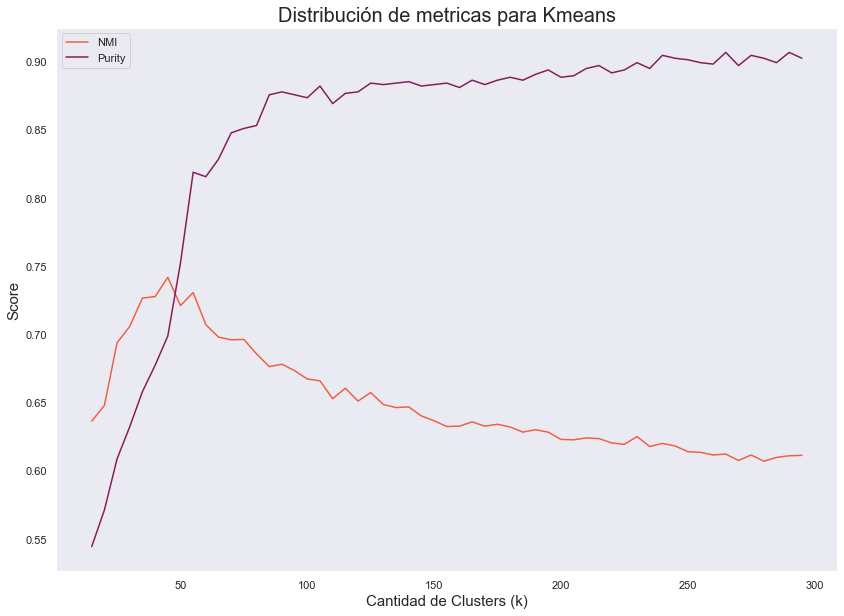

In [72]:
sns.set(style='dark', context='notebook', rc={'figure.figsize':(14,10)})
metrics_line = sns.lineplot(data=df, palette="rocket_r", dashes={"NMI":"", "Purity": ""})
metrics_line.set_title('Distribución de metricas para Kmeans', fontdict={'fontsize':20})
metrics_line.set_xlabel("Cantidad de Clusters (k)", fontdict={'fontsize':15})
metrics_line.set_ylabel("Score", fontdict={'fontsize':15})


# HDBSCAN

In [ ]:
best_model = None
best_params = None
best_score = None
for minSize in tqdm((50, 60, 70, 80)):
    for minSample in tqdm((10, 15, 30, 45, 60)):
        for epsilon in tqdm((0.2, 0.4, 0.5, 0.6, 0.8)):
            hdb = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = minSize, min_samples = minSample, cluster_selection_epsilon = epsilon)
            hdb.fit(trainReduced300)
            preds, strengths = hdbscan.approximate_predict(hdb, valReduced300)
            nmi = normalized_mutual_info_score(validation_labels, preds)
            if best_model == None: best_model = hdb
            if best_params == None: best_params = {'minSize':minSize, 'minSample':minSample}
            if best_score == None: best_score = nmi
            if nmi > best_score:
                best_model = hdb
                best_params = {'minSize':minSize, 'minSample':minSample}
                best_score = nmi

In [ ]:
print(best_score)

In [ ]:
# se me borraron los outputs pero me terminó quedando NMI = 0.61

In [10]:
best_params

{'minSize': 50, 'minSample': 15}

In [11]:
best_model.cluster_selection_epsilon

0.2

DESPUES DE PROBAR VARIAS VECES ME QUEDO CON MIN_SAMPLES = 15 Y MIN SIZE = 40 Y BUSCO ENTRE LOS EPSILON QUE DIERON MEJOR

In [13]:
best_model = None
best_score = None
scores = {}
for epsilon in tqdm((0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2)):
    hdb = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = 40, min_samples = 15, cluster_selection_epsilon = epsilon)
    hdb.fit(trainReduced300)
    preds, strengths = hdbscan.approximate_predict(hdb, valReduced300)
    nmi = normalized_mutual_info_score(validation_labels, preds)
    scores[epsilon] = nmi
    print(hdb.cluster_selection_epsilon)
    if best_model == None: best_model = hdb
    if best_score == None: best_score = nmi
    if nmi > best_score:
        best_model = hdb
        best_score = nmi

  8%|▊         | 1/12 [00:24<04:33, 24.83s/it]

1e-06


 17%|█▋        | 2/12 [00:49<04:08, 24.81s/it]

5e-06


 25%|██▌       | 3/12 [01:14<03:43, 24.84s/it]

1e-05


 33%|███▎      | 4/12 [01:39<03:18, 24.81s/it]

5e-05


 42%|████▏     | 5/12 [02:04<02:54, 24.86s/it]

0.0001


 50%|█████     | 6/12 [02:29<02:29, 24.87s/it]

0.0005


 58%|█████▊    | 7/12 [02:53<02:04, 24.86s/it]

0.001


 67%|██████▋   | 8/12 [03:18<01:39, 24.82s/it]

0.005


 75%|███████▌  | 9/12 [03:43<01:14, 24.75s/it]

0.01


 83%|████████▎ | 10/12 [04:07<00:49, 24.67s/it]

0.05


 92%|█████████▏| 11/12 [04:32<00:24, 24.84s/it]

0.1


100%|██████████| 12/12 [04:57<00:00, 24.81s/it]

0.2


In [5]:
print(best_model.min_cluster_size, best_model.min_samples, best_model.cluster_selection_epsilon)

40 15 0.001


In [7]:
print(best_score)

0.6705898623190356


In [4]:
with open('models/hdbscan', 'wb') as file:
    pickle.dump(best_model, file)

In [11]:
with open('models/hdbscan', 'rb') as file:
    best_model = pickle.load(file)

In [13]:
# Puntaje para test
preds, strengths = hdbscan.approximate_predict(best_model, testReduced300)
nmi = normalized_mutual_info_score(test_labels, preds)
print(nmi)

0.6752278430309506
